# Preprocess collected build job data

This notebook contains preprocessing steps before data labeling. In particular, it identified flaky job failures.

In [1]:
# imports
import pandas as pd
import plotly.express as px

In [2]:
# global variables

config = {
    "toImageButtonOptions": {
        "format": "png",  # one of png, svg, jpeg, webp
        "filename": "noise_dist",
        "height": 400,
        "width": 500,
        "scale": 3,
    }
}

### Load data

In [3]:
df = pd.read_csv("../../data/base/builds.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157496 entries, 0 to 157495
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               157496 non-null  int64  
 1   status           157496 non-null  object 
 2   stage            157496 non-null  object 
 3   name             157496 non-null  object 
 4   ref              157496 non-null  object 
 5   coverage         661 non-null     float64
 6   allow_failure    157496 non-null  bool   
 7   created_at       157496 non-null  object 
 8   started_at       142568 non-null  object 
 9   finished_at      146352 non-null  object 
 10  duration         142568 non-null  float64
 11  queued_duration  144568 non-null  float64
 12  failure_reason   31058 non-null   object 
 13  user             142487 non-null  float64
 14  commit           157496 non-null  object 
 15  pipeline         157496 non-null  int64  
 16  source           157496 non-null  obje

### Preprocess data

In [4]:
# keep only useful columns
cols = [
    "id",
    "status",
    "name",
    "ref",
    "created_at",
    "started_at",
    "finished_at",
    "duration",
    "queued_duration",
    "failure_reason",
    "commit",
    "pipeline",
    "user",
    "project",
    "group",
]
df = df.loc[:, cols]

# change type of column names with '_at' to datetime
for column in [col for col in df.columns.to_list() if "_at" in col]:
    df[column] = pd.to_datetime(df.loc[:, column], utc=True)

# remove non terminal job status
df = df[~df["status"].isin(["skipped", "manual", "created", "canceled"])]

df.shape

(140567, 15)

### Status distribution

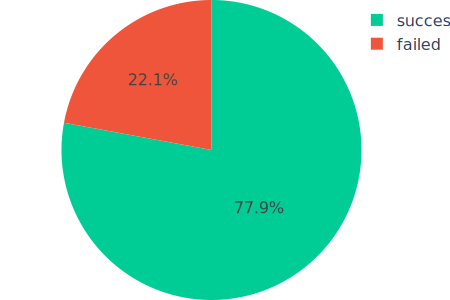

In [5]:
status = df["status"].value_counts().to_frame().reset_index()
colors = px.colors.qualitative.Plotly
fig = px.pie(
    status,
    values="count",
    names="status",
    color="status",
    color_discrete_map={
        "success": colors[2],
        "failed": colors[1],
        "skipped": px.colors.qualitative.Pastel2[7],
        "canceled": colors[4],
        "manual": colors[0],
        "created": colors[5],
    },
    width=450,
    height=300,
)
fig.update_layout(
    font_family="Rockwell",
    font_size=16,
    autosize=False,
    margin=dict(l=50, r=50, b=0, t=0, pad=0),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.95),
)
fig.show(renderer="svg", config=config)

In [6]:
df.to_csv("../../data/jobs.csv", index=False)

### Identify rerun jobs

In [7]:
grouped_jobs = (
    df.sort_values(by=["created_at"], ascending=True)
    .groupby(["project", "commit", "name"])
    .aggregate({"id": list, "status": list})
)

grouped_jobs["count"] = grouped_jobs["id"].apply(lambda x: len(x) - 1)
grouped_jobs["total"] = grouped_jobs["id"].apply(lambda x: len(x))
grouped_jobs.columns = ["id", "status", "count", "total"]
grouped_jobs = grouped_jobs.reset_index()[grouped_jobs.columns]
grouped_jobs

,id,status,count,total
0,[83897],[failed],0,1
1,[10167],[success],0,1
2,"[24005, 24006, 24007, 24539, 24542]","[failed, failed, success, success, success]",4,5
3,[148601],[success],0,1
4,[148600],[success],0,1
...,...,...,...,...
115321,[450822],[success],0,1
115322,"[406186, 406187, 406188]","[success, failed, success]",2,3
115323,"[448509, 448525, 448539]","[success, failed, success]",2,3
115324,[358361],[success],0,1


In [8]:
reruns = grouped_jobs[grouped_jobs["count"] > 0]
reruns

,id,status,count,total
2,"[24005, 24006, 24007, 24539, 24542]","[failed, failed, success, success, success]",4,5
9,"[148617, 148618, 148619]","[failed, failed, failed]",2,3
18,"[148627, 158792]","[success, failed]",1,2
20,"[93604, 102394]","[success, failed]",1,2
24,"[20713, 20737]","[success, success]",1,2
...,...,...,...,...
115312,"[453915, 453917]","[success, success]",1,2
115318,"[449990, 449991]","[failed, success]",1,2
115322,"[406186, 406187, 406188]","[success, failed, success]",2,3
115323,"[448509, 448525, 448539]","[success, failed, success]",2,3


In [9]:
reruns["count"].sum()

np.int64(25241)

In [10]:
reruns.to_csv("../../data/reruns.csv", index=False)

### Identify intermittent failures

In [11]:
import os

def is_file_empty(filepath:str):
    if not os.path.exists(filepath):
        return True
    return os.path.getsize(filepath) <= 0

In [12]:
df.set_index("id", inplace=True)

In [13]:
flaky_reruns = reruns[
    reruns["status"].map(lambda x: set(["success", "failed"]).issubset(x))
].reset_index(drop=True)

intermittent_failures_list = [] # include flaky job failures
intermittent_jobs_list = [] # include silent and flaky failures

for _, row in flaky_reruns.iterrows():
    ids_failed_in_suite = []
    for i, status in enumerate(row["status"]):

        job_id = row["id"][i]
        job = df.loc[job_id, :]
        job_log_path = f"../../data/logs/{job['project']}/{job['project']}_{job_id}.log"
        job_data = {
            "id": job_id,
            "failure_reason": job["failure_reason"],
            "project": job["project"],
            "status": job["status"],
            "log": job_log_path if not is_file_empty(job_log_path) else None,
        }
        intermittent_jobs_list.append(job_data)
        if status == "failed":
            intermittent_failures_list.append(job_data)

In [14]:
intermittent_failures = pd.DataFrame(intermittent_failures_list)
intermittent_failures = intermittent_failures.drop(columns=["status"])
intermittent_failures

,id,failure_reason,project,log
0,24005,unknown_failure,44,../../telus-flaky-build/data/logs/44/44_24005.log
1,24006,unknown_failure,44,../../telus-flaky-build/data/logs/44/44_24006.log
2,158792,script_failure,44,None
3,102394,script_failure,44,../../telus-flaky-build/data/logs/44/44_102394...
4,258172,script_failure,44,None
...,...,...,...,...
7758,447165,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_44...
7759,447168,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_44...
7760,449990,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_44...
7761,406187,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_40...


In [15]:
intermittent_jobs = pd.DataFrame(intermittent_jobs_list)
intermittent_jobs

,id,failure_reason,project,status,log
0,24005,unknown_failure,44,failed,../../telus-flaky-build/data/logs/44/44_24005.log
1,24006,unknown_failure,44,failed,../../telus-flaky-build/data/logs/44/44_24006.log
2,24007,NaN,44,success,None
3,24539,NaN,44,success,None
4,24542,NaN,44,success,None
...,...,...,...,...,...
16373,406187,script_failure,1374,failed,../../telus-flaky-build/data/logs/1374/1374_40...
16374,406188,NaN,1374,success,None
16375,448509,NaN,1374,success,None
16376,448525,script_failure,1374,failed,../../telus-flaky-build/data/logs/1374/1374_44...


In [16]:
intermittent_jobs.to_csv("../../data/intermittent_jobs.csv", index=False)
intermittent_failures.to_csv("../../data/intermittent_failures.csv", index=False)

In [17]:
len(intermittent_failures['project'].unique())

80

In [18]:
job_failures = df[df['status'] == 'failed']

In [19]:
cols = intermittent_failures.columns.tolist()
intermittent_failures = intermittent_failures.set_index("id").join(df, rsuffix="_right").reset_index()[cols + ["created_at"]]

/home/henri/Documents/ETS/telus-intermittent-failures/src/utils/vizualization.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



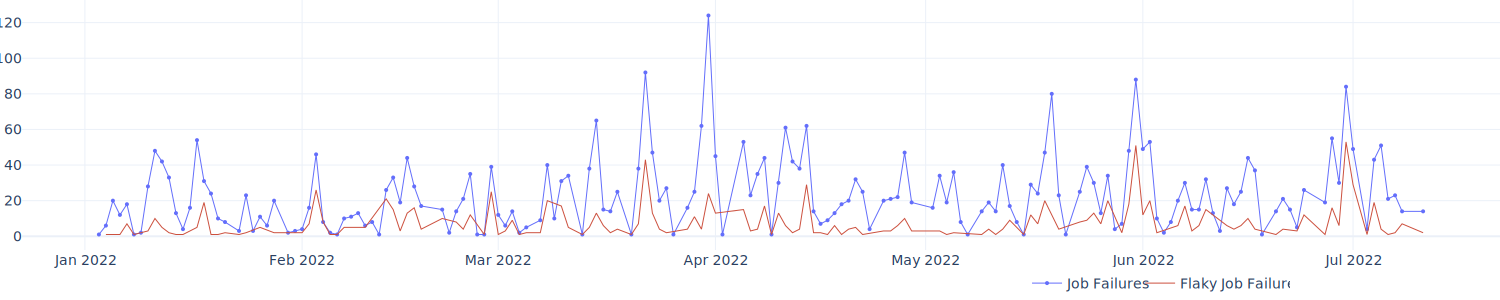

In [20]:
import importlib
from src.utils import vizualization as viz
importlib.invalidate_caches()
importlib.reload(viz)

data = [job_failures, intermittent_failures]
titles = ["Job Failures", "Flaky Job Failures"]
modes = ["lines+markers", "lines"]
colors = ["#636EFB", "#cc503e"]
start_date = "2022-01-01"
end_date = "2022-07-11"

viz.plot_count_timeseries(data, titles, modes, colors, start_date, end_date)

## Empty logs investigation

In [21]:
intermittent_failures['created_at'] = pd.to_datetime(intermittent_failures['created_at'], format='mixed', utc=True)
print(intermittent_failures[(intermittent_failures['created_at'].dt.strftime('%Y') == '2022')].shape[0])
intermittent_failures[(intermittent_failures['created_at'].dt.strftime('%Y') == '2022') & intermittent_failures['log'].isnull()]

1637


,id,failure_reason,project,log,created_at
2,158792,script_failure,44,None,2022-02-24 23:03:15.727000+00:00
9,164120,script_failure,44,None,2022-03-18 21:05:02.719000+00:00
23,162694,script_failure,44,None,2022-03-15 15:48:02.669000+00:00
53,162686,script_failure,44,None,2022-03-15 15:42:24.369000+00:00
82,173092,script_failure,125,None,2022-04-21 16:31:51.209000+00:00
...,...,...,...,...,...
5958,243158,script_failure,1183,None,2022-12-06 18:37:04.172000+00:00
5961,245873,script_failure,1183,None,2022-12-15 07:00:40.693000+00:00
5962,245874,script_failure,1183,None,2022-12-15 07:00:40.710000+00:00
5970,242066,script_failure,1186,None,2022-12-02 19:51:10.204000+00:00


In [22]:
intermittent_failures[intermittent_failures['log'].isnull()]['failure_reason'].value_counts()

failure_reason
script_failure                    1793
runner_system_failure              501
stuck_or_timeout_failure           132
job_execution_timeout               72
data_integrity_failure               3
deployment_rejected                  2
failed_outdated_deployment_job       2
missing_dependency_failure           1
forward_deployment_failure           1
Name: count, dtype: int64